### Get the BAG data (Basisregistratie Adressen & Gebouwen)

The BAG is neatly documented at **Stelselpedia** https://www.amsterdam.nl/stelselpedia/bag-index/catalogus-bag/. You can access the data publicly via the API. The swagger documentation of this API can be found here: https://api.data.amsterdam.nl/api/swagger/?url=/bag/docs/api-docs/bag%3Fformat%3Dopenapi 

Here I will get the pre-filtered dataset (only residences) from PostgreSQL/Postgis using the psycopg2 module. **Psycopg2** is a DB API 2.0 compliant PostgreSQL driver that is actively developed. It is designed for multi-threaded applications and manages its own connection pool. (Good starting material to get up-and-running on PostgreSQL: http://www.postgresqltutorial.com/)

In [1]:
# get the goodies
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from config import config # config.py --> config

In [20]:
BAG_QUERY_5 = """SELECT * FROM service_afvalcontainers.bag_verblijfsobject_woning LIMIT 5"""
BAG_QUERY_FULL = """SELECT * FROM service_afvalcontainers.bag_verblijfsobject_woning"""

In [17]:
def connect():
    """ Connect to PostgreSQL db server """
    conn = None
    try:
        # read connection parameters from config file
        params = config()
 
        # connect @PostgreSQL server
        print('--Connecting to PostgreSQL db--')
        conn = psycopg2.connect(**params)
 
        # create cursor
        cur = conn.cursor()
        
        print('Executing query:\n{}'.format(BAG_QUERY_5))
        cur.execute(SQL_QUERY)
 
        # display the PostgreSQL database server version
        rows = cur.fetchall()
        for row in rows:
            print(row)
       
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('--DB connection closed.--')

if __name__ == '__main__':
    connect()

--Connecting to PostgreSQL db--
Executing query:
SELECT * FROM service_afvalcontainers.bag_verblijfsobject_woning LIMIT 5
(datetime.date(2013, 2, 4), None, '03630000584182', '0363010000584182', 120, '0101000020407100000000000080B7FD4000000000088F1D41', 'Biesboschstraat', 20, '', '3', '03630000000831', '1800', '21')
(datetime.date(2013, 2, 4), None, '03630000584202', '0363010000584202', 125, '01010000204071000000000000F0B5FD4000000000F48E1D41', 'Biesboschstraat', 26, '', '3', '03630000000831', '1800', '21')
(datetime.date(2010, 9, 9), None, '03630000584209', '0363010000584209', 75, '0101000020407100000000000060B4FD4000000000608E1D41', 'Biesboschstraat', 29, '', '2', '03630000000831', '1800', '21')
(datetime.date(2010, 9, 9), None, '03630000584264', '0363010000584264', 77, '0101000020407100000000000040B2FD4000000000448E1D41', 'Biesboschstraat', 47, '', '2', '03630000000831', '1800', '21')
(datetime.date(2010, 9, 9), None, '03630000584271', '0363010000584271', 74, '01010000204071000000000

The above will import the adapter and try to connect to the database. If the connection fails a print statement will occur to STDOUT

In [18]:
# you can also read tables with psql
import pandas.io.sql as psql
params = config()
conn = psycopg2.connect(**params)
df= psql.read_sql(BAG_QUERY_5, conn)

In [12]:
df.geometrie[0]

'0101000020407100000000000080B7FD4000000000088F1D41'

In this case we ingest a geometry column that looks like `'0101000020407100000000000080B7FD4000000000088F1D41'`, a nasty string representation of Well Known Binary format. WKB is a multi-purpose format for serializing vector geometry data into a byte buffer. This can be loaded with the shapely.wkb module as such but it is a cumbersome operation on large Series (bytes or integer address expected instead of str instance). F.i. 

```df[geometry_col].map(shapely.wkb.loads)``` won't work on strings

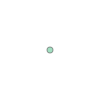

In [14]:
import shapely.wkb as wkb
wkb.loads(df['geometrie'][0], hex=True)

Much easier to ingest your data containing geomtrey columns with **GeoPandas**.It can not automatically read geom_col and crs from PostGIS. They must be specified explicitly:

In [21]:
import geopandas as gpd
geodf = gpd.read_postgis(BAG_QUERY_FULL, conn, geom_col='geometrie', 
                         crs = {'init': 'epsg:4326'} ,coerce_float=False)
print ('Geodataframe shape: {}'.format(geodf.shape))

Geodataframe shape: (434089, 13)


In [22]:
# Close the connection. Clean up.
conn.close()

In [23]:
geodf.head(2)

,begin_geldigheid,einde_geldigheid,id,landelijk_id,oppervlakte,geometrie,_openbare_ruimte_naam,_huisnummer,_huisletter,_huisnummer_toevoeging,buurt_id,gebruik_id,status_id
0,2013-02-04,None,03630000584182,0363010000584182,120,POINT (121720 484290),Biesboschstraat,20.0,,3,03630000000831,1800,21
1,2013-02-04,None,03630000584202,0363010000584202,125,POINT (121695 484285),Biesboschstraat,26.0,,3,03630000000831,1800,21


In [30]:
geodf[(geodf._openbare_ruimte_naam == 'Legmeerstraat') & (geodf._huisnummer == 76.0)]

,begin_geldigheid,einde_geldigheid,id,landelijk_id,oppervlakte,geometrie,_openbare_ruimte_naam,_huisnummer,_huisletter,_huisnummer_toevoeging,buurt_id,gebruik_id,status_id
125220,2010-09-09,None,03630000721088,0363010000721088,77,POINT (118478 485007),Legmeerstraat,76.0,,2,03630000000799,1800,21
274166,2010-09-09,None,03630000721087,0363010000721087,66,POINT (118478 485007),Legmeerstraat,76.0,,1,03630000000799,1800,21


In [126]:
import folium
amsterdam_map = folium.Map(location=[52.370216,  4.895168],
                  zoom_start=10,
                  tiles='cartodbpositron')

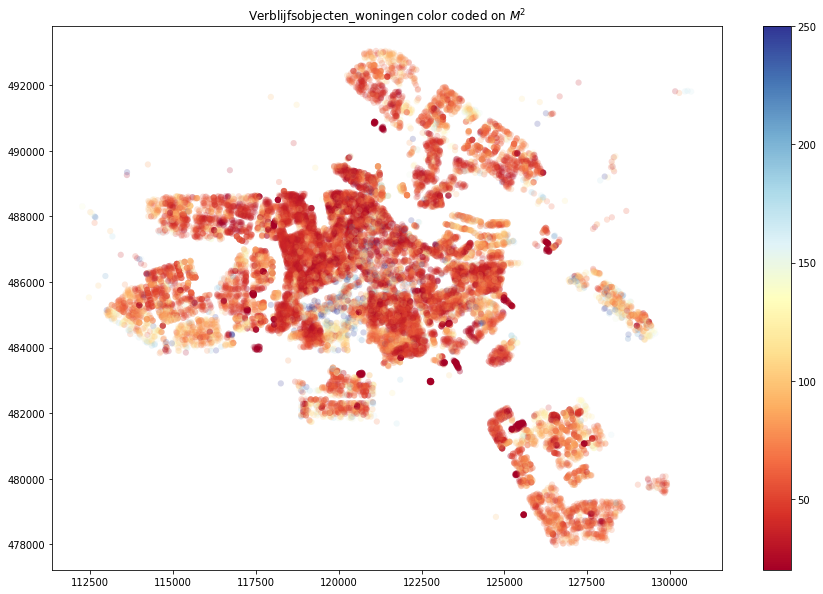

In [39]:
fig, ax = plt.subplots(figsize=[15,10])
kwargs=dict(edgecolor=None, linewidth=.1, alpha=.2)
cmap = plt.cm.RdYlBu
geodf.sample(n=25000,replace=False).plot(column='oppervlakte', cmap = cmap, 
                                         ax=ax, vmin = 35, vmax=250, **kwargs)
ax.set(title='Verblijfsobjecten_woningen color coded on $M{^2}$')
# add colorbar
vmin = 20; vmax = 250 # m2 lower/upper bound 
scalarmap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array of scalar mappable ..
scalarmap._A = []
fig.colorbar(scalarmap)

### geospatial clustering with DBSCAN

In [47]:
# we have geometry Point objects from which we can extract x, y 
geodf.geometrie[:2]

0    POINT (121720 484290)
1    POINT (121695 484285)
Name: geometrie, dtype: object

In [48]:
geodf['x'] = geodf['geometrie'].x
geodf['y'] = geodf['geometrie'].y

In [49]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

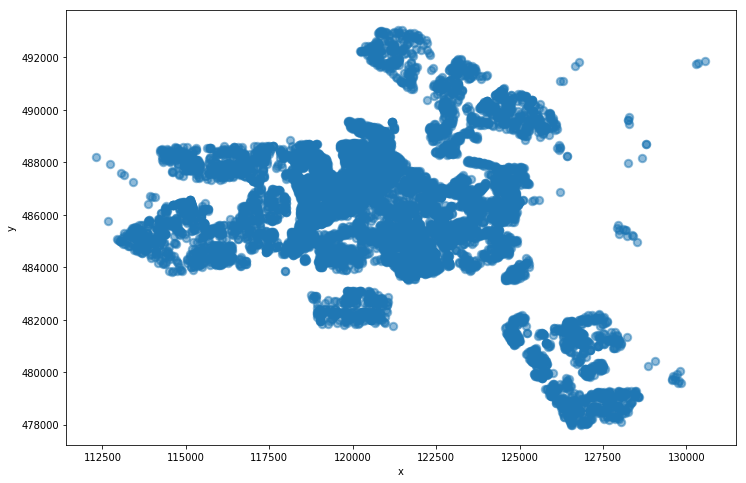

In [58]:
fig, ax = plt.subplots(1,1, figsize= [12,8])
geodf[['x', 'y']][:10000].plot.scatter(x='x', y='y', alpha=.5, ax=ax, s=55, linewidth = 2)

In [59]:
# represent points consistently as (lat, lon)
coords = geodf.as_matrix(columns=['x', 'y'])

# define epsilon as 10 kilometers, converted to radians for use by haversine
epsilon = 10 / kms_per_radian
print (epsilon)

0.0015696101377226162


In [ ]:
start_time = time.time()
db = (DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')
       .fit(np.radians(coords)))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

In [38]:
url = 'https://raw.githubusercontent.com/gboeing/urban-data-science/master/15-Spatial-Cluster-Analysis/data/summer-travel-gps-full.csv'

In [35]:
df= pd.read_csv(url, encoding='latin1')
df = df.sort_values(by = ['lat', 'lon'])

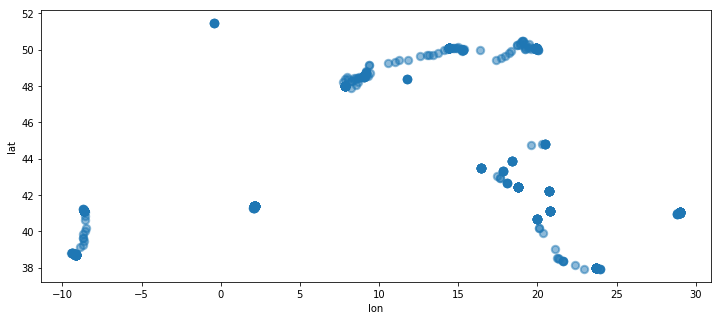

In [36]:
fig, ax = plt.subplots(1,1, figsize= [12,5])
df.plot.scatter(x='lon', y='lat', alpha=.5, ax=ax, s=55, linewidth = 2)

In [37]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['lat', 'lon'])

# define epsilon as 10 kilometers, converted to radians for use by haversine
epsilon = 10 / kms_per_radian
print (epsilon)

0.0015696101377226162


In [46]:
start_time = time.time()
db = (DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine')
       .fit(np.radians(coords)))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

In [50]:
db.components_

array([[0.66264508, 0.41412948],
       [0.66265247, 0.41414108],
       [0.66265254, 0.41414039],
       ...,
       [0.87431688, 0.25147796],
       [0.87436336, 0.34724014],
       [0.87443627, 0.25303427]])

[Text(0.5,1,'number of clusters = 18')]

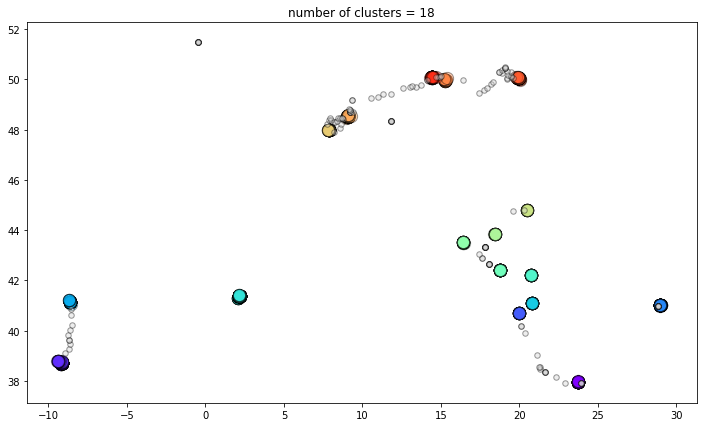

In [56]:
#get colors and plot all the points, color-coded by cluster 
#(or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize= [12,7])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for cluster_label, color in zip(unique_labels, colors):
    size= 150
    if cluster_label == -1: # noise is labeled -1 to appear smaller
        color ='lightgrey'
        size=30
    
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolors='k', s=size, alpha=.4)
ax.set(title = 'number of clusters = {}'.format(num_clusters))